### 1. Self defined classification model (Adaline with GD and SGD) ###

In [1]:
class AdalineGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    random_state : int
        The seed of the pseudo random number generator.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.activation(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

In [2]:
from numpy.random import seed

class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1, m=1):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.m = m
        if random_state:
            seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            
            batches_X = [X[k:k+self.m] for k in range(0,len(X),self.m)]
            batches_y = [y[k:k+self.m] for k in range(0,len(y),self.m)]
            cost = []
            for xi, target in zip(batches_X, batches_y):
                #print(xi, target)
                #self.update_mini_batch(mini_batch, eta)
                cost.append(self._update_weights(xi, target))
                
            #for xi, target in zip(X, y):
                #cost.append(self._update_weights(xi, target))
            #print(sum(cost))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(xi)
        error = (target.ravel() - output)
        #print(self.w_[1:].shape)
        #print(target.shape)
        #print(output.shape)
        #print(error.shape)
        self.w_[1:] += self.eta * xi.T.dot(error)
        self.w_[0] += self.eta * error.sum()
        cost = 0.5 * (error**2).sum()
        #print(cost)
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

### 2. Load dataset ###

In [3]:
# Do not modify
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.model_selection import train_test_split

X = pd.read_csv('./datasets/nba/X_train.csv')
y = pd.read_csv('./datasets/nba/y_train.csv')
X_test = pd.read_csv('./datasets/nba/X_test.csv')

def pd2np(df):
    return df.values
X_train = pd2np(X)
y_train = pd2np(y)
X_test = pd2np(X_test)

X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=0.3, random_state=0)

### 3.Linear and Polynominal Adaline ###

First, I tried the basic self-written adaline model, with both linear and polynominal features.   
However, the result shows less than 0.5 accuracy, which is not good.

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_valid_std = sc.transform(X_valid)

adas = AdalineSGD(n_iter=20, eta=0.000001, random_state=11, m=10, shuffle=True)
adas.fit(X_train_std, y_train)

# testing accuracy
y_pred = adas.predict(X_valid_std)
print('AdalineSGD Accuracy: %.2f' % accuracy_score(y_valid, y_pred))

for d in [2,3,4]:
    penta = PolynomialFeatures(degree=d)

    X_penta_train = penta.fit_transform(X_train_std)
    X_penta_valid = penta.transform(X_valid_std)
    X_penta_train_std = sc.fit_transform(X_penta_train)
    X_penta_valid_std = sc.transform(X_penta_valid)
    adas.fit(X_penta_train_std, y_train)
    y_pred = adas.predict(X_penta_valid_std)
    print('AdalineSGD (poly=%d) Accuracy: %.2f' % (d, accuracy_score(y_valid, y_pred)))

AdalineSGD Accuracy: 0.46
AdalineSGD (poly=2) Accuracy: 0.46
AdalineSGD (poly=3) Accuracy: 0.46
AdalineSGD (poly=4) Accuracy: 0.45


### 4. SGD classifier and Logistic classifier with sklearn ###

Next, I tried some classic classification model using sklearn. (including SGD classifier and logistic classifier)  
Both models provides about 0.5~0.6 accuracy, and logistic regression model with polynominal features is the best among these.

In [18]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

adas = SGDClassifier()
adas.fit(X_train_std, y_train)

# testing accuracy
y_pred = adas.predict(X_valid_std)
print('sklearn SGD Accuracy: %.2f' % accuracy_score(y_valid, y_pred))

#========================================================
for d in [2,3]:
    penta = PolynomialFeatures(degree=d)

    X_penta_train = penta.fit_transform(X_train_std)
    X_penta_valid = penta.transform(X_valid_std)
    X_penta_train_std = sc.fit_transform(X_penta_train)
    X_penta_valid_std = sc.transform(X_penta_valid)
    adas.fit(X_penta_train_std, y_train)
    y_pred = adas.predict(X_penta_valid_std)
    print('sklearn SGD (poly=%d) Accuracy: %.2f' % (d, accuracy_score(y_valid, y_pred)))

#==========================================================

lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(X_train_std, y_train)

# testing accuracy
y_pred = lr.predict(X_valid_std)
print('logistic regression Accuracy: %.2f' % accuracy_score(y_valid, y_pred))

#========================================================
for d in [2,3]:
    penta = PolynomialFeatures(degree=d)

    X_penta_train = penta.fit_transform(X_train_std)
    X_penta_valid = penta.transform(X_valid_std)
    X_penta_train_std = sc.fit_transform(X_penta_train)
    X_penta_valid_std = sc.transform(X_penta_valid)
    lr.fit(X_penta_train_std, y_train)
    y_pred = lr.predict(X_penta_valid_std)
    print('logistic regression (poly=%d) Accuracy: %.2f' % (d, accuracy_score(y_valid, y_pred)))


D:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
D:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


sklearn SGD Accuracy: 0.59
sklearn SGD (poly=2) Accuracy: 0.57
sklearn SGD (poly=3) Accuracy: 0.54
logistic regression Accuracy: 0.61
logistic regression (poly=2) Accuracy: 0.62
logistic regression (poly=3) Accuracy: 0.62


### 5.Random forest ### 

In addition, I tried using random forest classifier, it provides about 0.6 accuracy

In [19]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=200, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_valid)
print('Accuracy (forest): %.2f' % accuracy_score(y_valid, y_pred))


D:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Accuracy (forest): 0.60


### 6. Feature selection ### 

Base on the previos result of random forest,  
I plot the importance of the features in order to do feature selection.

 1) GAME_CLOCK                     0.200453
 2) SHOT_DIST                      0.200179
 3) SHOT_CLOCK                     0.177025
 4) CLOSE_DEF_DIST                 0.173898
 5) TOUCH_TIME                     0.140622
 6) PERIOD                         0.052434
 7) DRIBBLES                       0.048234
 8) PTS_TYPE                       0.007156


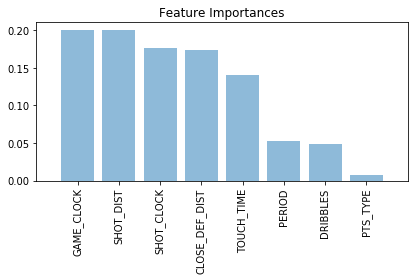

In [9]:
# inline plotting instead of popping out
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

importances = forest.feature_importances_
# get sort indices in descending order
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            X.columns.values[indices[f]], 
                            importances[indices[f]]))

plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center',
        alpha=0.5)

plt.xticks(range(X_train.shape[1]), 
           X.columns.values[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.savefig('./output/fig-forest-feature-importances.png', dpi=300)
plt.show()

### 7.Training with selected features ###

According to the previous result, I select three features : GAME_CLOCK, SHOT_DIST and SHOT_CLOCK.  
Then I evaluate three models : AdalineSGD, logistc regression and random forest to compare the results.   
Still, the logistc regression model gives the best accuracy

In [21]:
X2 = X[['GAME_CLOCK', 'SHOT_DIST','SHOT_CLOCK']].values


X_train, X_valid, y_train, y_valid = train_test_split(
        X2, y.values, test_size=0.3, random_state=0)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_valid_std = sc.transform(X_valid)

#==============================================

adas = AdalineSGD(n_iter=20, eta=0.001, random_state=1, m=1, shuffle=True)
adas.fit(X_train_std, y_train)
y_pred = adas.predict(X_valid_std)
print('AdalineSGD Accuracy: %.2f' % accuracy_score(y_valid, y_pred))

#==============================================

lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(X_train_std, y_train)
y_pred = lr.predict(X_valid_std)
print('Logistic Regression Accuracy: %.2f' % accuracy_score(y_valid, y_pred))

#==============================================

forest.fit(X_train_std, y_train)
y_pred = forest.predict(X_valid)
print('Random Forest Accuracy: %.2f' % accuracy_score(y_valid, y_pred))

AdalineSGD Accuracy: 0.46
Logistic Regression Accuracy: 0.60


D:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random Forest Accuracy: 0.54


### 8.Learning curve ###

Base on previous expirements, I select Logistic Regression model, which performs best, to plot the learning curve

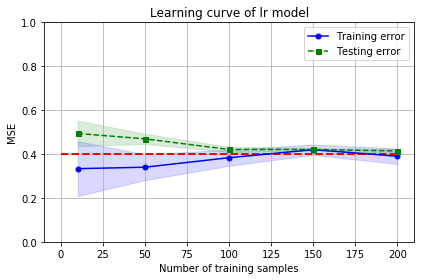

In [22]:
from sklearn.model_selection import learning_curve

def mse(model, X, y):
    return ((model.predict(X) - y)**2).mean()

lr = LogisticRegression()
train_sizes, train_scores, test_scores = learning_curve(estimator=lr, X=X2, y=y.values.ravel(), shuffle=True,
                                                        scoring=mse, train_sizes=[10,50,100,150,200])

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
    color='blue', marker='o',
    markersize=5,
    label='Training error')
plt.fill_between(train_sizes,
    train_mean+train_std,
    train_mean-train_std,
    alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
    color='green', linestyle='--',
    marker='s', markersize=5,
    label='Testing error')
plt.fill_between(train_sizes,
    test_mean+test_std,
    test_mean-test_std,
    alpha=0.15, color='green')

plt.hlines(y=0.4, xmin=0, xmax=200, color='red', linewidth=2, linestyle='--')

plt.title('Learning curve of lr model')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

As we can see in the figure, the model did not over-fit. Since the training error and the testing error are about the same.

### 9. Predict testing data ###

Finally, I use the logistic regression model to predict the testing data, and stored in a CSV file.